## Chapter 2 - Analysis: Bringing it all together and making decisions

Quintile analysis is a common framework for evaluating the efficacy of security factors.  
A factor is a method for scoring/ranking sets of securities. For a particular point in time and for a
particular set of securities, a factor can be represented as a pandas series where the index is an
array of the security identifiers and the values are the scores or ranks.  
If we take factor scores over time, we can, at each point in time, split the set of securities into 5
equal buckets, or quintiles, based on the order of the factor scores. There is nothing particularly
sacred about the number 5. We could have used 3 or 10. But we use 5 often. Finally, we track the
performance of each of the five buckets to determine if there is a meaningful difference in the
returns. We tend to focus more intently on the difference in returns of the bucket with the highest
rank relative to that of the lowest rank.

Let's start by setting some parameters and generating random data.  
Random data includes:
- **Returns**: generate random returns for specified number of securities and period.
- **Signals**: generate random signals for specified number of securities and periods and with prescribed level of correlation with Returns. In order for a factor to be useful, there must be some information or correlation between the scores/ranks and subsequent returns. 

In [1]:
import pandas as pd
import numpy as np

In [3]:
num_securities = 1000
num_periods = 1000
period_frequency = 'W'
start_date = '2000-12-31'

In [4]:
np.random.seed([3,1415])
means = [0, 0]
covariance = [[ 1., 5e-3],
 [5e-3, 1.]]

m = np.random.multivariate_normal(means, covariance,
 (num_periods, num_securities)).T

Generate a time series index and an index representing security ids.

In [5]:
ids = pd.Index(['s{:05d}'.format(s) for s in range(num_securities)], 'ID')
tidx = pd.date_range(start=start_date, periods=num_periods, freq=period_frequency)

Use them to create dataframes for returns and signals.

In [6]:
security_returns = pd.DataFrame(m[0] / 25 + 1e-7, tidx, ids)
security_signals = pd.DataFrame(m[1], tidx, ids)

Let's use python ```python pd.qcut``` to divide signals into quintile buckets for each period.

In [7]:
def qcut(s, q=5):
    labels = ['q{}'.format(i) for i in range(1, 6)]
    return pd.qcut(s, q, labels=labels)

cut = security_signals.stack().groupby(level=0).apply(qcut)

Use these cuts as an index on our returns.

In [8]:
returns_cut = security_returns.stack().rename('returns') \
 .to_frame().set_index(cut, append=True) \
 .swaplevel(2, 1).sort_index().squeeze() \
 .groupby(level=[0, 1]).mean().unstack()

Plot the returns.

C:\Users\IOZZIA\AppData\Local\conda\conda\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  app.launch_new_instance()


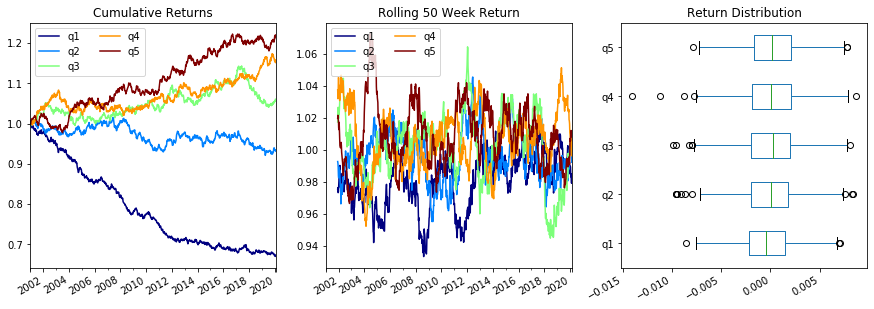

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

# Cumulative Returns
returns_cut.add(1).cumprod() \
 .plot(colormap='jet', ax=ax1, title="Cumulative Returns")
leg1 = ax1.legend(loc='upper left', ncol=2, prop={'size': 10}, fancybox=True)
leg1.get_frame().set_alpha(.8)

# Rolling 50 Week Return
returns_cut.add(1).rolling(50).apply(lambda x: x.prod()) \
 .plot(colormap='jet', ax=ax2, title="Rolling 50 Week Return")
leg2 = ax2.legend(loc='upper left', ncol=2, prop={'size': 10}, fancybox=True)
leg2.get_frame().set_alpha(.8)

# Return Distribution
returns_cut.plot.box(vert=False, ax=ax3, title="Return Distribution")
fig.autofmt_xdate()

Visualize quintile correlation with ```scatter_matrix```.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025BE26E4470>,
      dtype=object)

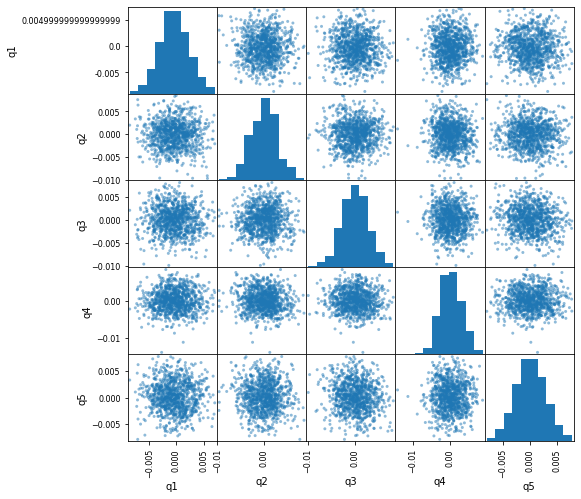

In [12]:
from pandas.plotting import scatter_matrix

scatter_matrix(returns_cut, alpha=0.5, figsize=(8, 8), diagonal='hist')

Calculate and visualize the Maximum Draw Down.

In [13]:
def max_dd(returns):
    """returns is a series"""
    r = returns.add(1).cumprod()
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = dd.argmin()
    start = r.loc[:end].argmax()
    return mdd, start, end

def max_dd_df(returns):
    """returns is a dataframe"""
    series = lambda x: pd.Series(x, ['Draw Down', 'Start', 'End'])
    return returns.apply(max_dd).apply(series)

In [14]:
max_dd_df(returns_cut)

C:\Users\IOZZIA\AppData\Local\conda\conda\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  
C:\Users\IOZZIA\AppData\Local\conda\conda\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  import sys


,Draw Down,Start,End
q1,-0.333527,2001-01-07,2020-02-16
q2,-0.092659,2007-06-10,2019-04-14
q3,-0.089682,2017-06-11,2019-07-21
q4,-0.058225,2003-03-16,2008-03-30
q5,-0.046822,2002-01-20,2003-07-06


C:\Users\IOZZIA\AppData\Local\conda\conda\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  
C:\Users\IOZZIA\AppData\Local\conda\conda\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  import sys


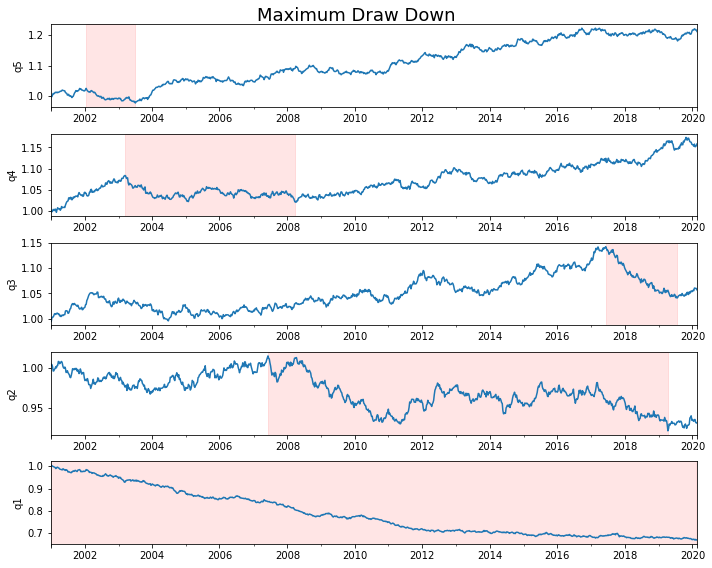

In [15]:
draw_downs = max_dd_df(returns_cut)

fig, axes = plt.subplots(5, 1, figsize=(10, 8))
for i, ax in enumerate(axes[::-1]):
    returns_cut.iloc[:, i].add(1).cumprod().plot(ax=ax)
    sd, ed = draw_downs[['Start', 'End']].iloc[i]
    ax.axvspan(sd, ed, alpha=0.1, color='r')
    ax.set_ylabel(returns_cut.columns[i])
fig.suptitle('Maximum Draw Down', fontsize=18)
fig.tight_layout()
plt.subplots_adjust(top=.95)

Calculate few statistics.

In [16]:
def frequency_of_time_series(df):
    start, end = df.index.min(), df.index.max()
    delta = end - start
    return round((len(df) - 1.) * 365.25 / delta.days, 2)

def annualized_return(df):
    freq = frequency_of_time_series(df)
    return df.add(1).prod() ** (1 / freq) - 1

def annualized_volatility(df):
    freq = frequency_of_time_series(df)
    return df.std().mul(freq ** .5)

def sharpe_ratio(df):
    return annualized_return(df) / annualized_volatility(df)

def describe(df):
    r = annualized_return(df).rename('Return')
    v = annualized_volatility(df).rename('Volatility')
    s = sharpe_ratio(df).rename('Sharpe')
    skew = df.skew().rename('Skew')
    kurt = df.kurt().rename('Kurtosis')
    desc = df.describe().T
    return pd.concat([r, v, s, skew, kurt, desc], axis=1).T.drop('count')

In [17]:
describe(returns_cut)

,q1,q2,q3,q4,q5
Return,-0.007609,-0.001375,0.001067,0.002821,0.003687
Volatility,0.019584,0.020445,0.020629,0.021185,0.020172
Sharpe,-0.388525,-0.067278,0.051709,0.133176,0.182792
Skew,0.040430,-0.085828,-0.078071,-0.067522,0.005652
Kurtosis,-0.174206,0.203038,0.026385,0.370249,-0.160678
mean,-0.000395,-0.000068,0.000060,0.000151,0.000196
std,0.002711,0.002830,0.002856,0.002933,0.002792
min,-0.008608,-0.009614,-0.009845,-0.014037,-0.007913
25%,-0.002196,-0.002018,-0.001956,-0.001833,-0.001694
50%,-0.000434,0.000065,0.000210,0.000029,0.000146
